In [1]:
!pip install anndata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tqdm as tq
import anndata as ad
# from scipy.sparse import csr_matrix
# from scipy.sparse import coo_matrix
from anndata.experimental.pytorch import AnnLoader

In [3]:
DATA = "/content/drive/MyDrive/STANFORD_CS236_PROJ/data"
MODELS = "/content/drive/MyDrive/STANFORD_CS236_PROJ/models_zip.v2.DONOR_0"

In [22]:
ad_train = ad.read_h5ad(f"{DATA}/ad_train.counts.donor0.h5ad")

In [23]:
ad_train.X = ad_train.X.astype(np.float32)

In [24]:
ad_train.X

<58240x18211 sparse matrix of type '<class 'numpy.float32'>'
	with 95146121 stored elements in Compressed Sparse Row format>

In [ ]:
batch_size = 64
shuffle = True

dataloader = AnnLoader(ad_train, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc_pp =  nn.Linear(256, 1)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        # BatchNorm layers in the encoder
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = self.leakyrelu(self.bn1(self.fc1(x)))
        x = self.leakyrelu(self.bn2(self.fc2(x)))

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        pp = torch.sigmoid(self.fc_pp(x))

        return mu, logvar, pp

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        # BatchNorm layers in the encoder
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.leakyrelu(self.bn1(self.fc1(x)))
        x = self.leakyrelu(self.bn2(self.fc2(x)))

        x = torch.exp(self.fc3(x))  # Use exp to ensure non-negative outputs for Poisson
        return x

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def zero_inflation_prob(self, z):
        return torch.sigmoid(self.fc_zero_inflation(z))

    def forward(self, x):
        mu, logvar, pp = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar, pp



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have a dataset (replace this with your actual data)
input_dim = 18211
latent_dim = 128

# Create VAE model
vae_model = VAE(input_dim, latent_dim).to(device)

In [ ]:
vae_model

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=18211, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=128, bias=True)
    (fc_pp): Linear(in_features=256, out_features=1, bias=True)
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=18211, bias=True)
    (leakyrelu): LeakyReLU(negative_slope=0.01)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1

In [ ]:
# def zero_inflated_poisson_loss(recon_x, x, mu, logvar, pp, beta):
#     poisson_loss = F.poisson_nll_loss(recon_x, x, log_input=False, reduction='none')
#     zero_prob = torch.exp(-pp)
#     extra_zeros_term = zero_prob * (x == 0).float()
#     a = 1-zero_prob.squeeze()
#     a_expanded = a.view(-1, 1)
#     zip_loss = poisson_loss * a_expanded + extra_zeros_term
#     # recon_loss = torch.mean(zip_loss)  # Calculate the mean loss across the batch
#     recon_loss = torch.sum(zip_loss)
#     kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     loss = recon_loss + beta*kl_div
#     return loss



In [ ]:
def zip_nll_loss(recon_x, x, pp):
    p_zero = pp + (1 - pp) * torch.exp(-recon_x)
    neg_log_p_zero = -torch.log(p_zero)
    epsilon = 10**-10
    neg_log_p_nonzero = - torch.log(1 - pp) + F.poisson_nll_loss(recon_x, x, log_input=False, reduction='none')
    zip_loss = neg_log_p_zero * (x == 0) + neg_log_p_nonzero * (x > 0)

    return zip_loss.sum()

In [ ]:
# Set up optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=0.0005)

# Training parameters
num_epochs = 500

# Save every save_interval epochs
save_interval = 50

beta = 1

# Training loop
loss_all = []
for epoch in range(num_epochs):
    total_loss = 0.0

    for batch_data in tq.tqdm(dataloader):
        batch_data = batch_data.X.to(device)
        bsize, _ = batch_data.shape
        optimizer.zero_grad()

        # print(batch_data.min(), batch_data.max())


        # Forward pass
        reconstructed_data, mu, logvar, pp = vae_model(batch_data)

        recon_loss = zip_nll_loss(reconstructed_data, batch_data, pp)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #     # kl_divergence /= bsize
        loss = recon_loss + beta * kl_divergence

        # Backward pass
        loss.backward()

        # Gradient Clipping (limiting gradient norms to max_norm=1.0)
        nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')
    loss_all.append(total_loss)

    # Save the model
    if (epoch + 1) % save_interval == 0:
        torch.save(vae_model.state_dict(), f"{MODELS}/model_zip_epoch_{epoch + 1}.pt")
        print(f"Model saved at epoch {epoch + 1}")

    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(custom_dataset)}')
    # loss_all.append(total_loss / len(custom_dataset))

100%|██████████| 910/910 [00:17<00:00, 51.70it/s]


Epoch [1/500], Loss: -217656984.87304688


100%|██████████| 910/910 [00:11<00:00, 77.07it/s]


Epoch [2/500], Loss: -238834607.40625


100%|██████████| 910/910 [00:10<00:00, 84.80it/s]


Epoch [3/500], Loss: -241182739.75


100%|██████████| 910/910 [00:12<00:00, 70.82it/s]


Epoch [4/500], Loss: -242587330.21875


100%|██████████| 910/910 [00:12<00:00, 71.95it/s]


Epoch [5/500], Loss: -243816407.71875


100%|██████████| 910/910 [00:11<00:00, 77.09it/s]


Epoch [6/500], Loss: -244685424.796875


100%|██████████| 910/910 [00:11<00:00, 79.96it/s]


Epoch [7/500], Loss: -245441125.546875


100%|██████████| 910/910 [00:11<00:00, 76.27it/s]


Epoch [8/500], Loss: -246189821.296875


100%|██████████| 910/910 [00:11<00:00, 78.51it/s]


Epoch [9/500], Loss: -246673109.984375


100%|██████████| 910/910 [00:10<00:00, 83.39it/s]


Epoch [10/500], Loss: -247183575.421875


100%|██████████| 910/910 [00:11<00:00, 76.49it/s]


Epoch [11/500], Loss: -247607129.546875


100%|██████████| 910/910 [00:11<00:00, 78.42it/s]


Epoch [12/500], Loss: -247937626.78125


100%|██████████| 910/910 [00:10<00:00, 84.32it/s]


Epoch [13/500], Loss: -248306152.875


100%|██████████| 910/910 [00:12<00:00, 73.80it/s]


Epoch [14/500], Loss: -248553625.15625


100%|██████████| 910/910 [00:11<00:00, 76.17it/s]


Epoch [15/500], Loss: -248798007.59375


100%|██████████| 910/910 [00:10<00:00, 85.08it/s]


Epoch [16/500], Loss: -249017289.390625


100%|██████████| 910/910 [00:11<00:00, 78.88it/s]


Epoch [17/500], Loss: -249232452.9375


100%|██████████| 910/910 [00:11<00:00, 77.25it/s]


Epoch [18/500], Loss: -249386743.171875


100%|██████████| 910/910 [00:10<00:00, 83.22it/s]


Epoch [19/500], Loss: -249584830.0


100%|██████████| 910/910 [00:11<00:00, 79.30it/s]


Epoch [20/500], Loss: -249779597.40625


100%|██████████| 910/910 [00:11<00:00, 77.32it/s]


Epoch [21/500], Loss: -249929997.4296875


100%|██████████| 910/910 [00:11<00:00, 81.65it/s]


Epoch [22/500], Loss: -250111366.484375


100%|██████████| 910/910 [00:11<00:00, 81.19it/s]


Epoch [23/500], Loss: -250236032.03125


100%|██████████| 910/910 [00:12<00:00, 74.56it/s]


Epoch [24/500], Loss: -250357552.015625


100%|██████████| 910/910 [00:11<00:00, 79.99it/s]


Epoch [25/500], Loss: -250473803.9375


100%|██████████| 910/910 [00:10<00:00, 89.53it/s]


Epoch [26/500], Loss: -250607870.203125


100%|██████████| 910/910 [00:11<00:00, 82.63it/s]


Epoch [27/500], Loss: -250688480.40625


100%|██████████| 910/910 [00:10<00:00, 89.71it/s]


Epoch [28/500], Loss: -250800858.109375


100%|██████████| 910/910 [00:10<00:00, 84.76it/s]


Epoch [29/500], Loss: -250891212.203125


100%|██████████| 910/910 [00:11<00:00, 81.61it/s]


Epoch [30/500], Loss: -250984769.328125


100%|██████████| 910/910 [00:10<00:00, 88.56it/s]


Epoch [31/500], Loss: -251055800.84375


100%|██████████| 910/910 [00:11<00:00, 80.94it/s]


Epoch [32/500], Loss: -251155331.375


100%|██████████| 910/910 [00:11<00:00, 81.55it/s]


Epoch [33/500], Loss: -251222505.734375


100%|██████████| 910/910 [00:10<00:00, 85.20it/s]


Epoch [34/500], Loss: -251289328.875


100%|██████████| 910/910 [00:11<00:00, 79.16it/s]


Epoch [35/500], Loss: -251396313.078125


100%|██████████| 910/910 [00:11<00:00, 76.28it/s]


Epoch [36/500], Loss: -251438105.5625


100%|██████████| 910/910 [00:10<00:00, 84.57it/s]


Epoch [37/500], Loss: -251532079.34375


100%|██████████| 910/910 [00:10<00:00, 82.80it/s]


Epoch [38/500], Loss: -251589376.5625


100%|██████████| 910/910 [00:11<00:00, 79.57it/s]


Epoch [39/500], Loss: -251674337.15625


100%|██████████| 910/910 [00:10<00:00, 86.30it/s]


Epoch [40/500], Loss: -251712945.921875


100%|██████████| 910/910 [00:10<00:00, 84.70it/s]


Epoch [41/500], Loss: -251826676.046875


100%|██████████| 910/910 [00:11<00:00, 79.65it/s]


Epoch [42/500], Loss: -251811491.6796875


100%|██████████| 910/910 [00:11<00:00, 82.43it/s]


Epoch [43/500], Loss: -251921155.390625


100%|██████████| 910/910 [00:11<00:00, 80.65it/s]


Epoch [44/500], Loss: -251991664.71875


100%|██████████| 910/910 [00:11<00:00, 77.09it/s]


Epoch [45/500], Loss: -252014177.953125


100%|██████████| 910/910 [00:11<00:00, 82.22it/s]


Epoch [46/500], Loss: -252104017.078125


100%|██████████| 910/910 [00:11<00:00, 82.01it/s]


Epoch [47/500], Loss: -252127466.9375


100%|██████████| 910/910 [00:11<00:00, 76.96it/s]


Epoch [48/500], Loss: -252147716.90625


100%|██████████| 910/910 [00:10<00:00, 83.30it/s]


Epoch [49/500], Loss: -252243401.921875


100%|██████████| 910/910 [00:11<00:00, 81.41it/s]


Epoch [50/500], Loss: -252303961.109375
Model saved at epoch 50


100%|██████████| 910/910 [00:12<00:00, 74.65it/s]


Epoch [51/500], Loss: -252326456.3125


100%|██████████| 910/910 [00:11<00:00, 80.60it/s]


Epoch [52/500], Loss: -252358606.9375


100%|██████████| 910/910 [00:10<00:00, 86.93it/s]


Epoch [53/500], Loss: -252418004.21875


100%|██████████| 910/910 [00:10<00:00, 83.20it/s]


Epoch [54/500], Loss: -252429791.359375


100%|██████████| 910/910 [00:10<00:00, 88.40it/s]


Epoch [55/500], Loss: -252518323.046875


100%|██████████| 910/910 [00:10<00:00, 87.36it/s]


Epoch [56/500], Loss: -252528182.015625


100%|██████████| 910/910 [00:11<00:00, 79.80it/s]


Epoch [57/500], Loss: -252598403.75


100%|██████████| 910/910 [00:10<00:00, 84.91it/s]


Epoch [58/500], Loss: -252577532.140625


100%|██████████| 910/910 [00:11<00:00, 80.50it/s]


Epoch [59/500], Loss: -252661746.640625


100%|██████████| 910/910 [00:11<00:00, 77.42it/s]


Epoch [60/500], Loss: -252726258.671875


100%|██████████| 910/910 [00:10<00:00, 89.60it/s]


Epoch [61/500], Loss: -252771290.328125


100%|██████████| 910/910 [00:10<00:00, 85.52it/s]


Epoch [62/500], Loss: -252728596.3125


100%|██████████| 910/910 [00:10<00:00, 82.99it/s]


Epoch [63/500], Loss: -252833784.140625


100%|██████████| 910/910 [00:09<00:00, 91.93it/s]


Epoch [64/500], Loss: -252851416.328125


100%|██████████| 910/910 [00:11<00:00, 79.82it/s]


Epoch [65/500], Loss: -252856974.28125


100%|██████████| 910/910 [00:11<00:00, 79.34it/s]


Epoch [66/500], Loss: -252885432.265625


100%|██████████| 910/910 [00:10<00:00, 87.22it/s]


Epoch [67/500], Loss: -252932044.109375


100%|██████████| 910/910 [00:11<00:00, 82.20it/s]


Epoch [68/500], Loss: -252985719.171875


100%|██████████| 910/910 [00:10<00:00, 84.49it/s]


Epoch [69/500], Loss: -253020880.0625


100%|██████████| 910/910 [00:10<00:00, 88.09it/s]


Epoch [70/500], Loss: -253028555.21875


100%|██████████| 910/910 [00:11<00:00, 81.78it/s]


Epoch [71/500], Loss: -253082643.765625


100%|██████████| 910/910 [00:10<00:00, 84.04it/s]


Epoch [72/500], Loss: -253101643.34375


100%|██████████| 910/910 [00:10<00:00, 84.35it/s]


Epoch [73/500], Loss: -253139461.546875


100%|██████████| 910/910 [00:11<00:00, 80.16it/s]


Epoch [74/500], Loss: -253158947.09375


100%|██████████| 910/910 [00:10<00:00, 86.57it/s]


Epoch [75/500], Loss: -253110932.734375


100%|██████████| 910/910 [00:10<00:00, 84.06it/s]


Epoch [76/500], Loss: -253195832.0625


100%|██████████| 910/910 [00:11<00:00, 80.74it/s]


Epoch [77/500], Loss: -253236443.3125


100%|██████████| 910/910 [00:10<00:00, 89.05it/s]


Epoch [78/500], Loss: -253250734.46875


100%|██████████| 910/910 [00:10<00:00, 84.22it/s]


Epoch [79/500], Loss: -253305106.578125


100%|██████████| 910/910 [00:11<00:00, 78.85it/s]


Epoch [80/500], Loss: -253326733.203125


100%|██████████| 910/910 [00:10<00:00, 84.56it/s]


Epoch [81/500], Loss: -253356024.0625


100%|██████████| 910/910 [00:11<00:00, 79.53it/s]


Epoch [82/500], Loss: -253381823.515625


100%|██████████| 910/910 [00:11<00:00, 76.91it/s]


Epoch [83/500], Loss: -253383557.609375


100%|██████████| 910/910 [00:10<00:00, 83.91it/s]


Epoch [84/500], Loss: -253424504.078125


100%|██████████| 910/910 [00:10<00:00, 87.53it/s]


Epoch [85/500], Loss: -253437537.859375


100%|██████████| 910/910 [00:10<00:00, 84.99it/s]


Epoch [86/500], Loss: -253469499.03125


100%|██████████| 910/910 [00:09<00:00, 97.56it/s]


Epoch [87/500], Loss: -253485729.796875


100%|██████████| 910/910 [00:10<00:00, 86.21it/s]


Epoch [88/500], Loss: -253506049.765625


100%|██████████| 910/910 [00:09<00:00, 91.09it/s]


Epoch [89/500], Loss: -253532802.265625


100%|██████████| 910/910 [00:09<00:00, 91.48it/s]


Epoch [90/500], Loss: -253549889.390625


100%|██████████| 910/910 [00:10<00:00, 85.05it/s]


Epoch [91/500], Loss: -253592534.328125


100%|██████████| 910/910 [00:09<00:00, 96.91it/s]


Epoch [92/500], Loss: -253594157.40625


100%|██████████| 910/910 [00:10<00:00, 86.29it/s]


Epoch [93/500], Loss: -253615993.296875


100%|██████████| 910/910 [00:10<00:00, 88.80it/s]


Epoch [94/500], Loss: -253637790.4375


100%|██████████| 910/910 [00:09<00:00, 94.45it/s]


Epoch [95/500], Loss: -253637310.09375


100%|██████████| 910/910 [00:10<00:00, 85.72it/s]


Epoch [96/500], Loss: -253657728.15625


100%|██████████| 910/910 [00:09<00:00, 94.14it/s]


Epoch [97/500], Loss: -253702092.453125


100%|██████████| 910/910 [00:10<00:00, 88.79it/s]


Epoch [98/500], Loss: -253701159.28125


100%|██████████| 910/910 [00:10<00:00, 89.25it/s]


Epoch [99/500], Loss: -253717161.171875


100%|██████████| 910/910 [00:09<00:00, 95.23it/s]


Epoch [100/500], Loss: -253761701.59375
Model saved at epoch 100


100%|██████████| 910/910 [00:10<00:00, 84.52it/s]


Epoch [101/500], Loss: -253777858.09375


100%|██████████| 910/910 [00:09<00:00, 92.98it/s]


Epoch [102/500], Loss: -253785185.984375


100%|██████████| 910/910 [00:10<00:00, 90.38it/s]


Epoch [103/500], Loss: -253806674.375


100%|██████████| 910/910 [00:10<00:00, 87.33it/s]


Epoch [104/500], Loss: -253812543.46875


100%|██████████| 910/910 [00:09<00:00, 96.04it/s]


Epoch [105/500], Loss: -253771904.40625


100%|██████████| 910/910 [00:10<00:00, 84.89it/s]


Epoch [106/500], Loss: -253849116.828125


100%|██████████| 910/910 [00:09<00:00, 91.47it/s]


Epoch [107/500], Loss: -253840599.375


100%|██████████| 910/910 [00:10<00:00, 90.76it/s]


Epoch [108/500], Loss: -253851173.03125


100%|██████████| 910/910 [00:10<00:00, 85.88it/s]


Epoch [109/500], Loss: -253894218.328125


100%|██████████| 910/910 [00:09<00:00, 97.08it/s]


Epoch [110/500], Loss: -253911848.375


100%|██████████| 910/910 [00:10<00:00, 85.79it/s] 


Epoch [111/500], Loss: -253946746.59375


100%|██████████| 910/910 [00:09<00:00, 91.38it/s]


Epoch [112/500], Loss: -253950188.5625


100%|██████████| 910/910 [00:09<00:00, 93.44it/s]


Epoch [113/500], Loss: -253996982.40625


100%|██████████| 910/910 [00:10<00:00, 85.78it/s]


Epoch [114/500], Loss: -253980633.578125


100%|██████████| 910/910 [00:09<00:00, 97.62it/s]


Epoch [115/500], Loss: -254005148.515625


100%|██████████| 910/910 [00:10<00:00, 86.19it/s]


Epoch [116/500], Loss: -254025961.6875


100%|██████████| 910/910 [00:10<00:00, 90.43it/s]


Epoch [117/500], Loss: -254035000.484375


100%|██████████| 910/910 [00:09<00:00, 91.95it/s]


Epoch [118/500], Loss: -254051106.53125


100%|██████████| 910/910 [00:10<00:00, 85.77it/s]


Epoch [119/500], Loss: -254097606.375


100%|██████████| 910/910 [00:09<00:00, 95.60it/s]


Epoch [120/500], Loss: -254079240.71875


100%|██████████| 910/910 [00:10<00:00, 87.96it/s]


Epoch [121/500], Loss: -254089418.984375


100%|██████████| 910/910 [00:10<00:00, 88.99it/s]


Epoch [122/500], Loss: -254111445.0625


100%|██████████| 910/910 [00:09<00:00, 94.79it/s]


Epoch [123/500], Loss: -254152025.578125


100%|██████████| 910/910 [00:10<00:00, 85.40it/s]


Epoch [124/500], Loss: -254093611.1875


100%|██████████| 910/910 [00:10<00:00, 89.99it/s]


Epoch [125/500], Loss: -254147997.828125


100%|██████████| 910/910 [00:10<00:00, 87.27it/s]


Epoch [126/500], Loss: -254179879.921875


100%|██████████| 910/910 [00:10<00:00, 87.35it/s]


Epoch [127/500], Loss: -254206297.046875


100%|██████████| 910/910 [00:09<00:00, 94.57it/s]


Epoch [128/500], Loss: -254198467.171875


100%|██████████| 910/910 [00:10<00:00, 86.70it/s]


Epoch [129/500], Loss: -254210960.328125


100%|██████████| 910/910 [00:09<00:00, 93.99it/s]


Epoch [130/500], Loss: -254224000.671875


100%|██████████| 910/910 [00:09<00:00, 92.69it/s] 


Epoch [131/500], Loss: -254249034.1875


100%|██████████| 910/910 [00:10<00:00, 87.06it/s]


Epoch [132/500], Loss: -254248465.546875


100%|██████████| 910/910 [00:09<00:00, 98.26it/s]


Epoch [133/500], Loss: -254249459.8125


100%|██████████| 910/910 [00:10<00:00, 87.70it/s]


Epoch [134/500], Loss: -254288168.609375


100%|██████████| 910/910 [00:09<00:00, 91.59it/s]


Epoch [135/500], Loss: -254306150.890625


100%|██████████| 910/910 [00:09<00:00, 93.24it/s]


Epoch [136/500], Loss: -254314716.859375


100%|██████████| 910/910 [00:10<00:00, 86.84it/s]


Epoch [137/500], Loss: -254313589.5625


100%|██████████| 910/910 [00:09<00:00, 98.01it/s] 


Epoch [138/500], Loss: -254343679.484375


100%|██████████| 910/910 [00:10<00:00, 85.94it/s]


Epoch [139/500], Loss: -254341125.96875


100%|██████████| 910/910 [00:09<00:00, 91.26it/s]


Epoch [140/500], Loss: -254352626.390625


100%|██████████| 910/910 [00:09<00:00, 92.82it/s]


Epoch [141/500], Loss: -254379803.25


100%|██████████| 910/910 [00:10<00:00, 84.64it/s]


Epoch [142/500], Loss: -254393070.078125


100%|██████████| 910/910 [00:09<00:00, 92.64it/s]


Epoch [143/500], Loss: -254387884.0625


100%|██████████| 910/910 [00:10<00:00, 87.15it/s] 


Epoch [144/500], Loss: -254417276.9375


100%|██████████| 910/910 [00:10<00:00, 87.98it/s]


Epoch [145/500], Loss: -254406649.375


100%|██████████| 910/910 [00:09<00:00, 97.06it/s] 


Epoch [146/500], Loss: -254423136.09375


100%|██████████| 910/910 [00:10<00:00, 88.29it/s]


Epoch [147/500], Loss: -254386672.375


100%|██████████| 910/910 [00:09<00:00, 91.39it/s]


Epoch [148/500], Loss: -254422636.5


100%|██████████| 910/910 [00:10<00:00, 87.92it/s]


Epoch [149/500], Loss: -254460841.859375


100%|██████████| 910/910 [00:10<00:00, 84.79it/s]


Epoch [150/500], Loss: -254465752.765625
Model saved at epoch 150


100%|██████████| 910/910 [00:09<00:00, 95.37it/s]


Epoch [151/500], Loss: -254480743.390625


100%|██████████| 910/910 [00:10<00:00, 86.39it/s]


Epoch [152/500], Loss: -254496968.59375


100%|██████████| 910/910 [00:09<00:00, 92.30it/s]


Epoch [153/500], Loss: -254508866.296875


100%|██████████| 910/910 [00:09<00:00, 91.80it/s]


Epoch [154/500], Loss: -254529031.765625


100%|██████████| 910/910 [00:10<00:00, 86.24it/s]


Epoch [155/500], Loss: -254519521.140625


100%|██████████| 910/910 [00:09<00:00, 94.94it/s]


Epoch [156/500], Loss: -254523433.890625


100%|██████████| 910/910 [00:10<00:00, 87.08it/s]


Epoch [157/500], Loss: -254522077.59375


100%|██████████| 910/910 [00:10<00:00, 89.36it/s]


Epoch [158/500], Loss: -254531186.328125


100%|██████████| 910/910 [00:09<00:00, 95.26it/s]


Epoch [159/500], Loss: -254545642.515625


100%|██████████| 910/910 [00:10<00:00, 86.73it/s] 


Epoch [160/500], Loss: -254558574.734375


100%|██████████| 910/910 [00:09<00:00, 96.40it/s]


Epoch [161/500], Loss: -254575241.328125


100%|██████████| 910/910 [00:10<00:00, 85.70it/s]


Epoch [162/500], Loss: -254589195.09375


100%|██████████| 910/910 [00:10<00:00, 86.01it/s]


Epoch [163/500], Loss: -254594744.828125


100%|██████████| 910/910 [00:09<00:00, 93.34it/s]


Epoch [164/500], Loss: -254618272.328125


100%|██████████| 910/910 [00:10<00:00, 85.85it/s]


Epoch [165/500], Loss: -254593933.046875


100%|██████████| 910/910 [00:09<00:00, 93.52it/s]


Epoch [166/500], Loss: -254625856.984375


100%|██████████| 910/910 [00:10<00:00, 90.21it/s] 


Epoch [167/500], Loss: -254627827.59375


100%|██████████| 910/910 [00:10<00:00, 87.73it/s]


Epoch [168/500], Loss: -254642038.640625


100%|██████████| 910/910 [00:09<00:00, 96.07it/s]


Epoch [169/500], Loss: -254662078.359375


100%|██████████| 910/910 [00:10<00:00, 86.40it/s]


Epoch [170/500], Loss: -254642635.3125


100%|██████████| 910/910 [00:09<00:00, 91.86it/s]


Epoch [171/500], Loss: -254614636.6875


100%|██████████| 910/910 [00:10<00:00, 89.94it/s]


Epoch [172/500], Loss: -254692438.484375


100%|██████████| 910/910 [00:10<00:00, 85.81it/s]


Epoch [173/500], Loss: -254701598.90625


100%|██████████| 910/910 [00:09<00:00, 96.90it/s]


Epoch [174/500], Loss: -254649012.453125


100%|██████████| 910/910 [00:10<00:00, 86.10it/s]


Epoch [175/500], Loss: -254720559.546875


100%|██████████| 910/910 [00:10<00:00, 87.08it/s]


Epoch [176/500], Loss: -254687675.46875


100%|██████████| 910/910 [00:10<00:00, 90.65it/s]


Epoch [177/500], Loss: -254689688.859375


100%|██████████| 910/910 [00:10<00:00, 85.17it/s]


Epoch [178/500], Loss: -254733643.875


100%|██████████| 910/910 [00:09<00:00, 92.73it/s]


Epoch [179/500], Loss: -254747270.171875


100%|██████████| 910/910 [00:10<00:00, 87.46it/s]


Epoch [180/500], Loss: -254749495.171875


100%|██████████| 910/910 [00:10<00:00, 85.21it/s]


Epoch [181/500], Loss: -254756362.15625


100%|██████████| 910/910 [00:09<00:00, 92.29it/s]


Epoch [182/500], Loss: -254752293.890625


100%|██████████| 910/910 [00:10<00:00, 85.39it/s]


Epoch [183/500], Loss: -254767853.75


100%|██████████| 910/910 [00:09<00:00, 91.02it/s]


Epoch [184/500], Loss: -254776396.34375


100%|██████████| 910/910 [00:10<00:00, 90.27it/s]


Epoch [185/500], Loss: -254787055.703125


100%|██████████| 910/910 [00:10<00:00, 85.54it/s]


Epoch [186/500], Loss: -254792423.0625


100%|██████████| 910/910 [00:09<00:00, 96.86it/s]


Epoch [187/500], Loss: -254802593.984375


100%|██████████| 910/910 [00:10<00:00, 86.99it/s]


Epoch [188/500], Loss: -254826649.609375


100%|██████████| 910/910 [00:10<00:00, 90.72it/s]


Epoch [189/500], Loss: -254828720.484375


100%|██████████| 910/910 [00:09<00:00, 93.09it/s]


Epoch [190/500], Loss: -254836854.4375


100%|██████████| 910/910 [00:10<00:00, 85.36it/s]


Epoch [191/500], Loss: -254828401.65625


100%|██████████| 910/910 [00:09<00:00, 95.97it/s]


Epoch [192/500], Loss: -254835978.78125


100%|██████████| 910/910 [00:10<00:00, 86.97it/s]


Epoch [193/500], Loss: -254848055.546875


100%|██████████| 910/910 [00:10<00:00, 90.12it/s]


Epoch [194/500], Loss: -254863214.828125


100%|██████████| 910/910 [00:09<00:00, 94.40it/s] 


Epoch [195/500], Loss: -254871333.828125


100%|██████████| 910/910 [00:10<00:00, 85.93it/s]


Epoch [196/500], Loss: -254877779.796875


100%|██████████| 910/910 [00:09<00:00, 95.79it/s]


Epoch [197/500], Loss: -254858635.21875


100%|██████████| 910/910 [00:10<00:00, 87.49it/s]


Epoch [198/500], Loss: -254877213.25


100%|██████████| 910/910 [00:10<00:00, 87.07it/s]


Epoch [199/500], Loss: -254889132.875


100%|██████████| 910/910 [00:09<00:00, 95.13it/s]


Epoch [200/500], Loss: -254867664.359375
Model saved at epoch 200


100%|██████████| 910/910 [00:10<00:00, 84.55it/s]


Epoch [201/500], Loss: -254900731.015625


100%|██████████| 910/910 [00:09<00:00, 92.13it/s]


Epoch [202/500], Loss: -254907875.46875


100%|██████████| 910/910 [00:10<00:00, 89.98it/s]


Epoch [203/500], Loss: -254909363.625


100%|██████████| 910/910 [00:10<00:00, 86.52it/s]


Epoch [204/500], Loss: -254944001.1875


100%|██████████| 910/910 [00:09<00:00, 95.71it/s]


Epoch [205/500], Loss: -254938030.015625


100%|██████████| 910/910 [00:10<00:00, 86.52it/s]


Epoch [206/500], Loss: -254905752.390625


100%|██████████| 910/910 [00:09<00:00, 92.51it/s]


Epoch [207/500], Loss: -254945833.265625


100%|██████████| 910/910 [00:10<00:00, 90.43it/s]


Epoch [208/500], Loss: -254947638.90625


100%|██████████| 910/910 [00:10<00:00, 84.80it/s]


Epoch [209/500], Loss: -254950965.734375


100%|██████████| 910/910 [00:09<00:00, 95.92it/s]


Epoch [210/500], Loss: -254952804.3125


100%|██████████| 910/910 [00:10<00:00, 85.97it/s]


Epoch [211/500], Loss: -254979569.78125


100%|██████████| 910/910 [00:10<00:00, 88.97it/s]


Epoch [212/500], Loss: -254985779.4375


100%|██████████| 910/910 [00:09<00:00, 92.32it/s]


Epoch [213/500], Loss: -254982796.640625


100%|██████████| 910/910 [00:10<00:00, 85.71it/s]


Epoch [214/500], Loss: -254990334.75


100%|██████████| 910/910 [00:09<00:00, 94.44it/s]


Epoch [215/500], Loss: -255020831.046875


100%|██████████| 910/910 [00:10<00:00, 87.11it/s]


Epoch [216/500], Loss: -255014906.625


100%|██████████| 910/910 [00:10<00:00, 86.83it/s]


Epoch [217/500], Loss: -255022228.0


100%|██████████| 910/910 [00:09<00:00, 94.70it/s]


Epoch [218/500], Loss: -254994897.1796875


100%|██████████| 910/910 [00:10<00:00, 85.95it/s]


Epoch [219/500], Loss: -255029656.890625


100%|██████████| 910/910 [00:09<00:00, 92.40it/s]


Epoch [220/500], Loss: -255045170.578125


100%|██████████| 910/910 [00:10<00:00, 87.65it/s] 


Epoch [221/500], Loss: -255023651.890625


100%|██████████| 910/910 [00:10<00:00, 84.88it/s]


Epoch [222/500], Loss: -255033537.890625


100%|██████████| 910/910 [00:09<00:00, 96.71it/s]


Epoch [223/500], Loss: -255044856.265625


100%|██████████| 910/910 [00:10<00:00, 86.69it/s]


Epoch [224/500], Loss: -255065346.0625


100%|██████████| 910/910 [00:09<00:00, 94.24it/s]


Epoch [225/500], Loss: -255057158.09375


100%|██████████| 910/910 [00:10<00:00, 88.81it/s]


Epoch [226/500], Loss: -255080574.546875


100%|██████████| 910/910 [00:10<00:00, 86.73it/s]


Epoch [227/500], Loss: -255094017.21875


100%|██████████| 910/910 [00:09<00:00, 96.27it/s]


Epoch [228/500], Loss: -255099295.21875


100%|██████████| 910/910 [00:10<00:00, 87.01it/s] 


Epoch [229/500], Loss: -255085714.28125


100%|██████████| 910/910 [00:09<00:00, 93.07it/s]


Epoch [230/500], Loss: -255092428.90625


100%|██████████| 910/910 [00:10<00:00, 90.52it/s]


Epoch [231/500], Loss: -255092988.546875


100%|██████████| 910/910 [00:10<00:00, 85.26it/s]


Epoch [232/500], Loss: -255102963.484375


100%|██████████| 910/910 [00:09<00:00, 95.71it/s]


Epoch [233/500], Loss: -255118972.71875


100%|██████████| 910/910 [00:10<00:00, 83.92it/s]


Epoch [234/500], Loss: -255117936.84375


100%|██████████| 910/910 [00:09<00:00, 93.39it/s]


Epoch [235/500], Loss: -255115099.390625


100%|██████████| 910/910 [00:09<00:00, 92.37it/s]


Epoch [236/500], Loss: -255122469.828125


100%|██████████| 910/910 [00:10<00:00, 87.05it/s]


Epoch [237/500], Loss: -255140198.15625


100%|██████████| 910/910 [00:09<00:00, 98.52it/s]


Epoch [238/500], Loss: -255146386.265625


100%|██████████| 910/910 [00:10<00:00, 85.54it/s]


Epoch [239/500], Loss: -255156990.421875


100%|██████████| 910/910 [00:10<00:00, 89.74it/s]


Epoch [240/500], Loss: -255133610.453125


100%|██████████| 910/910 [00:09<00:00, 91.81it/s]


Epoch [241/500], Loss: -255159891.90625


100%|██████████| 910/910 [00:10<00:00, 87.19it/s]


Epoch [242/500], Loss: -255161066.140625


100%|██████████| 910/910 [00:09<00:00, 99.62it/s] 


Epoch [243/500], Loss: -255170538.109375


100%|██████████| 910/910 [00:10<00:00, 87.16it/s] 


Epoch [244/500], Loss: -255178835.625


100%|██████████| 910/910 [00:09<00:00, 91.20it/s]


Epoch [245/500], Loss: -255183004.984375


100%|██████████| 910/910 [00:09<00:00, 93.40it/s]


Epoch [246/500], Loss: -255152028.640625


100%|██████████| 910/910 [00:10<00:00, 86.07it/s]


Epoch [247/500], Loss: -255193651.171875


100%|██████████| 910/910 [00:09<00:00, 98.11it/s]


Epoch [248/500], Loss: -255191570.046875


100%|██████████| 910/910 [00:10<00:00, 86.01it/s]


Epoch [249/500], Loss: -255201177.203125


100%|██████████| 910/910 [00:10<00:00, 90.85it/s]


Epoch [250/500], Loss: -255200598.484375
Model saved at epoch 250


100%|██████████| 910/910 [00:09<00:00, 91.78it/s]


Epoch [251/500], Loss: -255206783.0


100%|██████████| 910/910 [00:10<00:00, 84.19it/s]


Epoch [252/500], Loss: -255209651.59375


100%|██████████| 910/910 [00:09<00:00, 97.00it/s]


Epoch [253/500], Loss: -255186401.296875


100%|██████████| 910/910 [00:10<00:00, 87.43it/s]


Epoch [254/500], Loss: -255194944.8125


100%|██████████| 910/910 [00:10<00:00, 90.26it/s]


Epoch [255/500], Loss: -255251332.9921875


100%|██████████| 910/910 [00:09<00:00, 92.68it/s]


Epoch [256/500], Loss: -255238443.328125


100%|██████████| 910/910 [00:10<00:00, 85.59it/s]


Epoch [257/500], Loss: -255236791.140625


100%|██████████| 910/910 [00:10<00:00, 90.73it/s]


Epoch [258/500], Loss: -255235146.203125


100%|██████████| 910/910 [00:10<00:00, 86.51it/s]


Epoch [259/500], Loss: -255251582.25


100%|██████████| 910/910 [00:10<00:00, 85.56it/s]


Epoch [260/500], Loss: -255256957.53125


100%|██████████| 910/910 [00:09<00:00, 92.30it/s]


Epoch [261/500], Loss: -255253018.453125


100%|██████████| 910/910 [00:10<00:00, 85.27it/s] 


Epoch [262/500], Loss: -255262621.96875


100%|██████████| 910/910 [00:09<00:00, 91.82it/s]


Epoch [263/500], Loss: -255270622.21875


100%|██████████| 910/910 [00:10<00:00, 88.91it/s]


Epoch [264/500], Loss: -255258530.984375


100%|██████████| 910/910 [00:10<00:00, 85.33it/s]


Epoch [265/500], Loss: -255267905.578125


100%|██████████| 910/910 [00:09<00:00, 93.81it/s]


Epoch [266/500], Loss: -255280963.953125


100%|██████████| 910/910 [00:11<00:00, 82.14it/s]


Epoch [267/500], Loss: -255278926.875


100%|██████████| 910/910 [00:11<00:00, 82.37it/s]


Epoch [268/500], Loss: -255284071.453125


100%|██████████| 910/910 [00:09<00:00, 93.16it/s]


Epoch [269/500], Loss: -255288111.453125


100%|██████████| 910/910 [00:10<00:00, 83.68it/s]


Epoch [270/500], Loss: -255305023.65625


100%|██████████| 910/910 [00:10<00:00, 90.87it/s]


Epoch [271/500], Loss: -255287651.828125


100%|██████████| 910/910 [00:10<00:00, 87.19it/s]


Epoch [272/500], Loss: -255316511.375


100%|██████████| 910/910 [00:10<00:00, 85.05it/s]


Epoch [273/500], Loss: -255310026.609375


100%|██████████| 910/910 [00:09<00:00, 95.89it/s] 


Epoch [274/500], Loss: -255319918.40625


100%|██████████| 910/910 [00:10<00:00, 84.77it/s]


Epoch [275/500], Loss: -255328625.9375


100%|██████████| 910/910 [00:10<00:00, 89.45it/s]


Epoch [276/500], Loss: -255323718.625


100%|██████████| 910/910 [00:10<00:00, 89.10it/s]


Epoch [277/500], Loss: -255330935.359375


100%|██████████| 910/910 [00:10<00:00, 85.23it/s]


Epoch [278/500], Loss: -255341616.296875


100%|██████████| 910/910 [00:09<00:00, 95.99it/s]


Epoch [279/500], Loss: -255332406.15625


100%|██████████| 910/910 [00:10<00:00, 85.09it/s]


Epoch [280/500], Loss: -255349108.078125


100%|██████████| 910/910 [00:10<00:00, 87.58it/s]


Epoch [281/500], Loss: -255350734.765625


100%|██████████| 910/910 [00:10<00:00, 90.50it/s]


Epoch [282/500], Loss: -255346988.46875


100%|██████████| 910/910 [00:11<00:00, 81.88it/s]


Epoch [283/500], Loss: -255342754.796875


100%|██████████| 910/910 [00:10<00:00, 89.51it/s]


Epoch [284/500], Loss: -255348425.453125


100%|██████████| 910/910 [00:10<00:00, 87.67it/s]


Epoch [285/500], Loss: -255394712.796875


100%|██████████| 910/910 [00:10<00:00, 85.99it/s]


Epoch [286/500], Loss: -255370316.734375


100%|██████████| 910/910 [00:09<00:00, 94.24it/s]


Epoch [287/500], Loss: -255373954.09375


100%|██████████| 910/910 [00:10<00:00, 84.27it/s]


Epoch [288/500], Loss: -255381427.84375


100%|██████████| 910/910 [00:10<00:00, 89.81it/s]


Epoch [289/500], Loss: -255374298.625


100%|██████████| 910/910 [00:10<00:00, 88.42it/s]


Epoch [290/500], Loss: -255379953.734375


100%|██████████| 910/910 [00:11<00:00, 82.60it/s]


Epoch [291/500], Loss: -255389836.453125


100%|██████████| 910/910 [00:09<00:00, 91.92it/s]


Epoch [292/500], Loss: -255389089.828125


100%|██████████| 910/910 [00:10<00:00, 83.99it/s]


Epoch [293/500], Loss: -255393341.703125


100%|██████████| 910/910 [00:10<00:00, 85.27it/s]


Epoch [294/500], Loss: -255387238.296875


100%|██████████| 910/910 [00:10<00:00, 89.46it/s]


Epoch [295/500], Loss: -255424166.46875


100%|██████████| 910/910 [00:11<00:00, 81.73it/s]


Epoch [296/500], Loss: -255415108.609375


100%|██████████| 910/910 [00:10<00:00, 87.42it/s]


Epoch [297/500], Loss: -255399996.5


100%|██████████| 910/910 [00:10<00:00, 88.48it/s]


Epoch [298/500], Loss: -255418622.5625


100%|██████████| 910/910 [00:11<00:00, 82.31it/s]


Epoch [299/500], Loss: -255422436.8125


100%|██████████| 910/910 [00:09<00:00, 91.79it/s]


Epoch [300/500], Loss: -255432727.078125
Model saved at epoch 300


100%|██████████| 910/910 [00:11<00:00, 82.18it/s]


Epoch [301/500], Loss: -255435247.453125


100%|██████████| 910/910 [00:10<00:00, 83.74it/s]


Epoch [302/500], Loss: -255437536.984375


100%|██████████| 910/910 [00:09<00:00, 92.72it/s]


Epoch [303/500], Loss: -255444596.46875


100%|██████████| 910/910 [00:11<00:00, 82.60it/s]


Epoch [304/500], Loss: -255455510.6875


100%|██████████| 910/910 [00:10<00:00, 88.84it/s]


Epoch [305/500], Loss: -255451300.078125


100%|██████████| 910/910 [00:10<00:00, 89.64it/s]


Epoch [306/500], Loss: -255448188.109375


100%|██████████| 910/910 [00:10<00:00, 84.21it/s]


Epoch [307/500], Loss: -255447304.984375


100%|██████████| 910/910 [00:09<00:00, 94.66it/s]


Epoch [308/500], Loss: -255442896.0


100%|██████████| 910/910 [00:10<00:00, 86.16it/s]


Epoch [309/500], Loss: -255461121.78125


100%|██████████| 910/910 [00:10<00:00, 87.51it/s]


Epoch [310/500], Loss: -255472670.59375


100%|██████████| 910/910 [00:10<00:00, 90.09it/s]


Epoch [311/500], Loss: -255478804.296875


100%|██████████| 910/910 [00:10<00:00, 84.50it/s]


Epoch [312/500], Loss: -255485188.296875


100%|██████████| 910/910 [00:09<00:00, 91.67it/s]


Epoch [313/500], Loss: -255468180.25


100%|██████████| 910/910 [00:10<00:00, 85.79it/s]


Epoch [314/500], Loss: -255486208.609375


100%|██████████| 910/910 [00:11<00:00, 82.28it/s]


Epoch [315/500], Loss: -255485937.265625


100%|██████████| 910/910 [00:09<00:00, 91.36it/s]


Epoch [316/500], Loss: -255487072.296875


100%|██████████| 910/910 [00:10<00:00, 82.76it/s]


Epoch [317/500], Loss: -255485789.921875


100%|██████████| 910/910 [00:10<00:00, 85.57it/s]


Epoch [318/500], Loss: -255508103.953125


100%|██████████| 910/910 [00:10<00:00, 88.68it/s]


Epoch [319/500], Loss: -255508612.609375


100%|██████████| 910/910 [00:11<00:00, 81.20it/s]


Epoch [320/500], Loss: -255521068.84375


100%|██████████| 910/910 [00:10<00:00, 90.38it/s]


Epoch [321/500], Loss: -255530314.40625


100%|██████████| 910/910 [00:10<00:00, 85.33it/s]


Epoch [322/500], Loss: -255513642.25


100%|██████████| 910/910 [00:10<00:00, 85.15it/s]


Epoch [323/500], Loss: -255509977.609375


100%|██████████| 910/910 [00:09<00:00, 95.94it/s]


Epoch [324/500], Loss: -255525193.328125


100%|██████████| 910/910 [00:10<00:00, 85.23it/s]


Epoch [325/500], Loss: -255521756.796875


100%|██████████| 910/910 [00:10<00:00, 86.55it/s]


Epoch [326/500], Loss: -255520485.546875


100%|██████████| 910/910 [00:10<00:00, 87.60it/s]


Epoch [327/500], Loss: -255529451.59375


100%|██████████| 910/910 [00:10<00:00, 83.61it/s]


Epoch [328/500], Loss: -255524588.890625


100%|██████████| 910/910 [00:09<00:00, 94.03it/s]


Epoch [329/500], Loss: -255536695.765625


100%|██████████| 910/910 [00:10<00:00, 86.46it/s]


Epoch [330/500], Loss: -255547487.96875


100%|██████████| 910/910 [00:10<00:00, 87.80it/s]


Epoch [331/500], Loss: -255546803.46875


100%|██████████| 910/910 [00:09<00:00, 91.12it/s]


Epoch [332/500], Loss: -255555814.578125


100%|██████████| 910/910 [00:10<00:00, 85.63it/s]


Epoch [333/500], Loss: -255543661.046875


100%|██████████| 910/910 [00:10<00:00, 86.40it/s]


Epoch [334/500], Loss: -255557951.515625


100%|██████████| 910/910 [00:10<00:00, 85.44it/s]


Epoch [335/500], Loss: -255559611.515625


100%|██████████| 910/910 [00:11<00:00, 81.51it/s]


Epoch [336/500], Loss: -255567812.984375


100%|██████████| 910/910 [00:09<00:00, 92.95it/s]


Epoch [337/500], Loss: -255558651.125


100%|██████████| 910/910 [00:10<00:00, 85.29it/s]


Epoch [338/500], Loss: -255565416.765625


100%|██████████| 910/910 [00:10<00:00, 90.00it/s]


Epoch [339/500], Loss: -255547224.125


100%|██████████| 910/910 [00:10<00:00, 89.40it/s]


Epoch [340/500], Loss: -255577938.890625


100%|██████████| 910/910 [00:11<00:00, 82.71it/s]


Epoch [341/500], Loss: -255589175.703125


100%|██████████| 910/910 [00:09<00:00, 94.62it/s]


Epoch [342/500], Loss: -255569157.8125


100%|██████████| 910/910 [00:10<00:00, 84.32it/s]


Epoch [343/500], Loss: -255572710.625


100%|██████████| 910/910 [00:10<00:00, 87.85it/s]


Epoch [344/500], Loss: -255588264.703125


100%|██████████| 910/910 [00:09<00:00, 92.39it/s]


Epoch [345/500], Loss: -255588052.6875


100%|██████████| 910/910 [00:10<00:00, 84.51it/s]


Epoch [346/500], Loss: -255611403.921875


100%|██████████| 910/910 [00:09<00:00, 94.18it/s]


Epoch [347/500], Loss: -255590191.0625


100%|██████████| 910/910 [00:10<00:00, 84.76it/s]


Epoch [348/500], Loss: -255622037.21875


100%|██████████| 910/910 [00:10<00:00, 84.83it/s]


Epoch [349/500], Loss: -255606763.296875


100%|██████████| 910/910 [00:09<00:00, 94.60it/s]


Epoch [350/500], Loss: -255601358.921875
Model saved at epoch 350


100%|██████████| 910/910 [00:11<00:00, 81.04it/s]


Epoch [351/500], Loss: -255627131.28125


100%|██████████| 910/910 [00:10<00:00, 88.37it/s]


Epoch [352/500], Loss: -255625132.3125


100%|██████████| 910/910 [00:10<00:00, 87.40it/s]


Epoch [353/500], Loss: -255614885.453125


100%|██████████| 910/910 [00:10<00:00, 83.32it/s]


Epoch [354/500], Loss: -255601397.625


100%|██████████| 910/910 [00:10<00:00, 90.06it/s]


Epoch [355/500], Loss: -255597975.78125


100%|██████████| 910/910 [00:11<00:00, 81.96it/s]


Epoch [356/500], Loss: -255647799.59375


100%|██████████| 910/910 [00:11<00:00, 80.52it/s]


Epoch [357/500], Loss: -255623917.125


100%|██████████| 910/910 [00:09<00:00, 91.06it/s]


Epoch [358/500], Loss: -255621783.21875


100%|██████████| 910/910 [00:10<00:00, 82.85it/s]


Epoch [359/500], Loss: -255636620.46875


100%|██████████| 910/910 [00:10<00:00, 85.52it/s]


Epoch [360/500], Loss: -255642018.796875


100%|██████████| 910/910 [00:10<00:00, 88.05it/s]


Epoch [361/500], Loss: -255648592.8125


100%|██████████| 910/910 [00:11<00:00, 82.55it/s]


Epoch [362/500], Loss: -255605544.3125


100%|██████████| 910/910 [00:10<00:00, 89.83it/s]


Epoch [363/500], Loss: -255625985.921875


100%|██████████| 910/910 [00:10<00:00, 84.00it/s]


Epoch [364/500], Loss: -255650780.4375


100%|██████████| 910/910 [00:11<00:00, 82.43it/s]


Epoch [365/500], Loss: -255645747.265625


100%|██████████| 910/910 [00:09<00:00, 92.89it/s]


Epoch [366/500], Loss: -255668074.015625


100%|██████████| 910/910 [00:11<00:00, 82.55it/s]


Epoch [367/500], Loss: -255674549.78125


100%|██████████| 910/910 [00:10<00:00, 86.13it/s]


Epoch [368/500], Loss: -255674749.84375


100%|██████████| 910/910 [00:10<00:00, 86.51it/s]


Epoch [369/500], Loss: -255679587.515625


100%|██████████| 910/910 [00:11<00:00, 82.27it/s]


Epoch [370/500], Loss: -255656616.25


100%|██████████| 910/910 [00:10<00:00, 89.80it/s]


Epoch [371/500], Loss: -255674476.6875


100%|██████████| 910/910 [00:10<00:00, 85.32it/s]


Epoch [372/500], Loss: -255643447.515625


100%|██████████| 910/910 [00:10<00:00, 84.16it/s]


Epoch [373/500], Loss: -255665505.59375


100%|██████████| 910/910 [00:09<00:00, 93.91it/s]


Epoch [374/500], Loss: -255665055.390625


100%|██████████| 910/910 [00:10<00:00, 83.26it/s]


Epoch [375/500], Loss: -255656644.15625


100%|██████████| 910/910 [00:10<00:00, 88.86it/s]


Epoch [376/500], Loss: -255687939.8125


100%|██████████| 910/910 [00:10<00:00, 87.44it/s]


Epoch [377/500], Loss: -255679512.15625


100%|██████████| 910/910 [00:10<00:00, 82.89it/s]


Epoch [378/500], Loss: -255677263.609375


100%|██████████| 910/910 [00:09<00:00, 92.52it/s]


Epoch [379/500], Loss: -255687467.359375


100%|██████████| 910/910 [00:10<00:00, 84.03it/s]


Epoch [380/500], Loss: -255696556.84375


100%|██████████| 910/910 [00:10<00:00, 84.37it/s]


Epoch [381/500], Loss: -255693845.4375


100%|██████████| 910/910 [00:10<00:00, 89.68it/s]


Epoch [382/500], Loss: -255690559.3125


100%|██████████| 910/910 [00:11<00:00, 79.50it/s]


Epoch [383/500], Loss: -255687030.1875


100%|██████████| 910/910 [00:10<00:00, 85.68it/s]


Epoch [384/500], Loss: -255701379.046875


100%|██████████| 910/910 [00:10<00:00, 87.23it/s]


Epoch [385/500], Loss: -255708738.453125


100%|██████████| 910/910 [00:11<00:00, 81.94it/s]


Epoch [386/500], Loss: -255696763.859375


100%|██████████| 910/910 [00:09<00:00, 93.49it/s]


Epoch [387/500], Loss: -255708711.328125


100%|██████████| 910/910 [00:10<00:00, 84.81it/s]


Epoch [388/500], Loss: -255717134.609375


100%|██████████| 910/910 [00:10<00:00, 85.82it/s]


Epoch [389/500], Loss: -255699189.015625


100%|██████████| 910/910 [00:10<00:00, 89.97it/s]


Epoch [390/500], Loss: -255724159.9375


100%|██████████| 910/910 [00:11<00:00, 78.53it/s]


Epoch [391/500], Loss: -255726444.15625


100%|██████████| 910/910 [00:10<00:00, 88.32it/s]


Epoch [392/500], Loss: -255714496.859375


100%|██████████| 910/910 [00:10<00:00, 86.67it/s]


Epoch [393/500], Loss: -255733563.453125


100%|██████████| 910/910 [00:11<00:00, 81.94it/s]


Epoch [394/500], Loss: -255738921.9375


100%|██████████| 910/910 [00:09<00:00, 93.89it/s]


Epoch [395/500], Loss: -255731146.875


100%|██████████| 910/910 [00:10<00:00, 85.08it/s]


Epoch [396/500], Loss: -255699012.875


100%|██████████| 910/910 [00:10<00:00, 84.65it/s]


Epoch [397/500], Loss: -255732796.4375


100%|██████████| 910/910 [00:10<00:00, 83.59it/s]


Epoch [398/500], Loss: -255755215.515625


100%|██████████| 910/910 [00:11<00:00, 80.34it/s]


Epoch [399/500], Loss: -255762196.34375


100%|██████████| 910/910 [00:10<00:00, 88.84it/s]


Epoch [400/500], Loss: -255658138.671875
Model saved at epoch 400


100%|██████████| 910/910 [00:10<00:00, 86.01it/s]


Epoch [401/500], Loss: -255740709.15625


100%|██████████| 910/910 [00:11<00:00, 80.04it/s]


Epoch [402/500], Loss: -255761556.015625


100%|██████████| 910/910 [00:10<00:00, 86.68it/s]


Epoch [403/500], Loss: -255737417.140625


100%|██████████| 910/910 [00:10<00:00, 85.75it/s]


Epoch [404/500], Loss: -255715270.3125


100%|██████████| 910/910 [00:11<00:00, 81.50it/s]


Epoch [405/500], Loss: -255772238.578125


100%|██████████| 910/910 [00:10<00:00, 90.07it/s]


Epoch [406/500], Loss: -255752217.984375


100%|██████████| 910/910 [00:11<00:00, 80.03it/s]


Epoch [407/500], Loss: -255762367.359375


100%|██████████| 910/910 [00:11<00:00, 82.10it/s]


Epoch [408/500], Loss: -255791856.796875


100%|██████████| 910/910 [00:10<00:00, 90.30it/s]


Epoch [409/500], Loss: -255761695.34375


100%|██████████| 910/910 [00:10<00:00, 83.06it/s]


Epoch [410/500], Loss: -255781991.734375


100%|██████████| 910/910 [00:10<00:00, 88.58it/s]


Epoch [411/500], Loss: -255796791.3125


100%|██████████| 910/910 [00:10<00:00, 85.56it/s]


Epoch [412/500], Loss: -255783800.59375


100%|██████████| 910/910 [00:10<00:00, 83.11it/s]


Epoch [413/500], Loss: -255774232.234375


100%|██████████| 910/910 [00:09<00:00, 93.18it/s]


Epoch [414/500], Loss: -255771872.296875


100%|██████████| 910/910 [00:10<00:00, 82.98it/s]


Epoch [415/500], Loss: -255802705.390625


100%|██████████| 910/910 [00:10<00:00, 87.72it/s]


Epoch [416/500], Loss: -255792065.84375


100%|██████████| 910/910 [00:10<00:00, 88.10it/s]


Epoch [417/500], Loss: -255787978.328125


100%|██████████| 910/910 [00:11<00:00, 81.92it/s]


Epoch [418/500], Loss: -255781034.0


100%|██████████| 910/910 [00:09<00:00, 91.19it/s]


Epoch [419/500], Loss: -255803916.8125


100%|██████████| 910/910 [00:10<00:00, 83.75it/s]


Epoch [420/500], Loss: -255803609.578125


100%|██████████| 910/910 [00:10<00:00, 84.20it/s]


Epoch [421/500], Loss: -255796859.96875


100%|██████████| 910/910 [00:09<00:00, 93.06it/s]


Epoch [422/500], Loss: -255806061.21875


100%|██████████| 910/910 [00:11<00:00, 82.52it/s]


Epoch [423/500], Loss: -255828261.546875


100%|██████████| 910/910 [00:10<00:00, 88.80it/s]


Epoch [424/500], Loss: -255805919.03125


100%|██████████| 910/910 [00:10<00:00, 86.25it/s]


Epoch [425/500], Loss: -255812740.34375


100%|██████████| 910/910 [00:11<00:00, 82.26it/s]


Epoch [426/500], Loss: -255824748.4375


100%|██████████| 910/910 [00:09<00:00, 92.76it/s]


Epoch [427/500], Loss: -255796851.984375


100%|██████████| 910/910 [00:11<00:00, 79.94it/s]


Epoch [428/500], Loss: -255833997.296875


100%|██████████| 910/910 [00:11<00:00, 81.75it/s]


Epoch [429/500], Loss: -255829211.4375


100%|██████████| 910/910 [00:10<00:00, 86.42it/s]


Epoch [430/500], Loss: -255835900.75


100%|██████████| 910/910 [00:11<00:00, 78.84it/s]


Epoch [431/500], Loss: -255832163.671875


100%|██████████| 910/910 [00:10<00:00, 84.20it/s]


Epoch [432/500], Loss: -255840491.0


100%|██████████| 910/910 [00:10<00:00, 84.53it/s]


Epoch [433/500], Loss: -255828513.828125


100%|██████████| 910/910 [00:11<00:00, 78.99it/s]


Epoch [434/500], Loss: -255827674.59375


100%|██████████| 910/910 [00:10<00:00, 85.65it/s]


Epoch [435/500], Loss: -255840231.375


100%|██████████| 910/910 [00:11<00:00, 81.03it/s]


Epoch [436/500], Loss: -255857799.59375


100%|██████████| 910/910 [00:11<00:00, 77.92it/s]


Epoch [437/500], Loss: -255852326.15625


100%|██████████| 910/910 [00:10<00:00, 85.44it/s]


Epoch [438/500], Loss: -255851906.328125


100%|██████████| 910/910 [00:11<00:00, 78.50it/s]


Epoch [439/500], Loss: -255839610.078125


100%|██████████| 910/910 [00:11<00:00, 77.52it/s]


Epoch [440/500], Loss: -255863047.53125


100%|██████████| 910/910 [00:10<00:00, 86.58it/s]


Epoch [441/500], Loss: -255850772.71875


100%|██████████| 910/910 [00:11<00:00, 78.42it/s]


Epoch [442/500], Loss: -255842963.90625


100%|██████████| 910/910 [00:11<00:00, 80.87it/s]


Epoch [443/500], Loss: -255842971.171875


100%|██████████| 910/910 [00:10<00:00, 85.10it/s]


Epoch [444/500], Loss: -255858420.125


100%|██████████| 910/910 [00:11<00:00, 78.32it/s]


Epoch [445/500], Loss: -255838613.109375


100%|██████████| 910/910 [00:11<00:00, 82.26it/s]


Epoch [446/500], Loss: -255846632.6875


100%|██████████| 910/910 [00:10<00:00, 87.45it/s]


Epoch [447/500], Loss: -255862230.625


100%|██████████| 910/910 [00:10<00:00, 82.98it/s]


Epoch [448/500], Loss: -255875882.484375


100%|██████████| 910/910 [00:09<00:00, 92.03it/s]


Epoch [449/500], Loss: -255871281.9375


100%|██████████| 910/910 [00:10<00:00, 83.55it/s]


Epoch [450/500], Loss: -255860318.90625
Model saved at epoch 450


100%|██████████| 910/910 [00:10<00:00, 83.05it/s]


Epoch [451/500], Loss: -255855783.2265625


100%|██████████| 910/910 [00:09<00:00, 91.69it/s]


Epoch [452/500], Loss: -255863087.078125


100%|██████████| 910/910 [00:10<00:00, 83.89it/s]


Epoch [453/500], Loss: -255879119.5


100%|██████████| 910/910 [00:10<00:00, 89.49it/s]


Epoch [454/500], Loss: -255891519.203125


100%|██████████| 910/910 [00:10<00:00, 88.71it/s]


Epoch [455/500], Loss: -255887590.5625


100%|██████████| 910/910 [00:10<00:00, 84.31it/s]


Epoch [456/500], Loss: -255895319.453125


100%|██████████| 910/910 [00:09<00:00, 95.04it/s]


Epoch [457/500], Loss: -255893083.0625


100%|██████████| 910/910 [00:11<00:00, 81.82it/s]


Epoch [458/500], Loss: -255891912.09375


100%|██████████| 910/910 [00:10<00:00, 87.72it/s]


Epoch [459/500], Loss: -255875831.0


100%|██████████| 910/910 [00:10<00:00, 88.41it/s]


Epoch [460/500], Loss: -255859613.015625


100%|██████████| 910/910 [00:10<00:00, 83.26it/s]


Epoch [461/500], Loss: -255895143.65625


100%|██████████| 910/910 [00:09<00:00, 93.65it/s]


Epoch [462/500], Loss: -255896360.421875


100%|██████████| 910/910 [00:10<00:00, 84.66it/s]


Epoch [463/500], Loss: -255896569.125


100%|██████████| 910/910 [00:10<00:00, 85.79it/s]


Epoch [464/500], Loss: -255891473.09375


100%|██████████| 910/910 [00:09<00:00, 91.68it/s]


Epoch [465/500], Loss: -255913429.609375


100%|██████████| 910/910 [00:11<00:00, 80.96it/s]


Epoch [466/500], Loss: -255909039.0625


100%|██████████| 910/910 [00:10<00:00, 89.46it/s]


Epoch [467/500], Loss: -255902210.4375


100%|██████████| 910/910 [00:10<00:00, 85.50it/s]


Epoch [468/500], Loss: -255888825.328125


100%|██████████| 910/910 [00:11<00:00, 82.55it/s]


Epoch [469/500], Loss: -255903126.03125


100%|██████████| 910/910 [00:09<00:00, 95.39it/s]


Epoch [470/500], Loss: -255903334.984375


100%|██████████| 910/910 [00:10<00:00, 84.01it/s]


Epoch [471/500], Loss: -255900131.53125


100%|██████████| 910/910 [00:10<00:00, 88.83it/s]


Epoch [472/500], Loss: -255912841.046875


100%|██████████| 910/910 [00:10<00:00, 90.89it/s]


Epoch [473/500], Loss: -255932370.90625


100%|██████████| 910/910 [00:10<00:00, 84.84it/s]


Epoch [474/500], Loss: -255952583.90625


100%|██████████| 910/910 [00:09<00:00, 94.31it/s]


Epoch [475/500], Loss: -255921591.984375


100%|██████████| 910/910 [00:10<00:00, 86.13it/s]


Epoch [476/500], Loss: -255909397.71875


100%|██████████| 910/910 [00:10<00:00, 88.94it/s]


Epoch [477/500], Loss: -255928100.40625


100%|██████████| 910/910 [00:09<00:00, 91.67it/s]


Epoch [478/500], Loss: -255937653.34375


100%|██████████| 910/910 [00:10<00:00, 83.48it/s]


Epoch [479/500], Loss: -255900876.75


100%|██████████| 910/910 [00:09<00:00, 95.00it/s]


Epoch [480/500], Loss: -255937107.546875


100%|██████████| 910/910 [00:10<00:00, 86.95it/s]


Epoch [481/500], Loss: -255942041.4375


100%|██████████| 910/910 [00:10<00:00, 89.33it/s]


Epoch [482/500], Loss: -255953589.5


100%|██████████| 910/910 [00:09<00:00, 92.58it/s]


Epoch [483/500], Loss: -255943127.640625


100%|██████████| 910/910 [00:10<00:00, 84.77it/s]


Epoch [484/500], Loss: -255941518.515625


100%|██████████| 910/910 [00:09<00:00, 93.81it/s]


Epoch [485/500], Loss: -255934286.234375


100%|██████████| 910/910 [00:10<00:00, 85.89it/s]


Epoch [486/500], Loss: -255934544.796875


100%|██████████| 910/910 [00:10<00:00, 86.85it/s]


Epoch [487/500], Loss: -255949978.890625


100%|██████████| 910/910 [00:09<00:00, 92.91it/s]


Epoch [488/500], Loss: -255976521.9375


100%|██████████| 910/910 [00:10<00:00, 85.94it/s]


Epoch [489/500], Loss: -255969686.984375


100%|██████████| 910/910 [00:09<00:00, 94.13it/s]


Epoch [490/500], Loss: -255950245.09375


100%|██████████| 910/910 [00:10<00:00, 87.10it/s]


Epoch [491/500], Loss: -255963791.84375


100%|██████████| 910/910 [00:10<00:00, 88.81it/s]


Epoch [492/500], Loss: -255963970.734375


100%|██████████| 910/910 [00:09<00:00, 94.34it/s]


Epoch [493/500], Loss: -255974277.625


100%|██████████| 910/910 [00:10<00:00, 84.65it/s] 


Epoch [494/500], Loss: -255954047.78125


100%|██████████| 910/910 [00:09<00:00, 93.83it/s]


Epoch [495/500], Loss: -255937840.234375


100%|██████████| 910/910 [00:10<00:00, 87.31it/s]


Epoch [496/500], Loss: -255961299.09375


100%|██████████| 910/910 [00:10<00:00, 85.74it/s]


Epoch [497/500], Loss: -255971079.828125


100%|██████████| 910/910 [00:09<00:00, 93.30it/s]


Epoch [498/500], Loss: -255960565.828125


100%|██████████| 910/910 [00:10<00:00, 85.84it/s]


Epoch [499/500], Loss: -255971002.796875


100%|██████████| 910/910 [00:09<00:00, 94.78it/s]


Epoch [500/500], Loss: -255979003.328125
Model saved at epoch 500


In [ ]:
batch_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
reconstructed_data, mu, logvar, pp = vae_model(batch_data)
# F.poisson_nll_loss(reconstructed_data, batch_data, log_input=False, reduction='sum')

In [ ]:
batch_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
reconstructed_data

tensor([[0.0054, 0.0070, 0.1184,  ..., 0.0314, 0.0953, 0.0548],
        [0.0253, 0.0090, 0.0096,  ..., 0.1143, 0.1087, 0.1151],
        [0.0017, 0.0030, 0.0030,  ..., 0.0756, 0.2420, 0.0947],
        ...,
        [0.0032, 0.0481, 0.0152,  ..., 0.0186, 0.2104, 0.0476],
        [0.0038, 0.0107, 0.0807,  ..., 0.0477, 0.0540, 0.0706],
        [0.0046, 0.0589, 0.0060,  ..., 0.0731, 0.0523, 0.0754]],
       device='cuda:0', grad_fn=<ExpBackward0>)

In [ ]:
import matplotlib.pyplot as plt

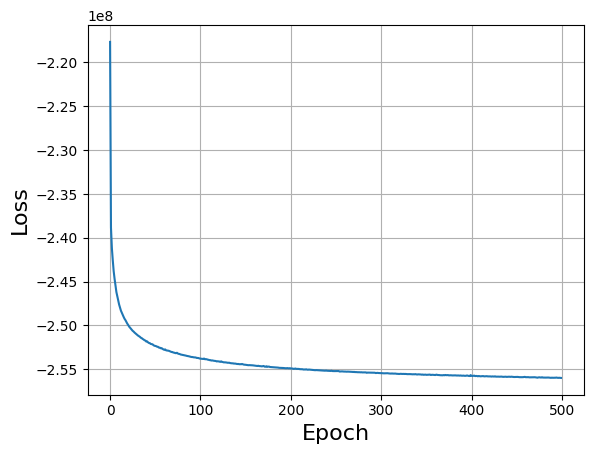

In [ ]:
plt.plot(loss_all)
# plt.ylim([10**9, 1.2*10**9])

plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.grid()

In [ ]:
df_loss = pd.DataFrame({"Epoch":range(num_epochs), "Loss":loss_all})
df_loss["Epoch"] = df_loss["Epoch"]+1

df_loss.to_csv(f"{DATA}/model_loss.tsv", sep="\t", index=None)

# Loading best model

In [ ]:
saved_model_path = f"{MODELS}/model_zip_epoch_200.pt"

vae_model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
import numpy as np
batch_size = 64
#data_loader = DataLoader(customdataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store encoded representations and labels
encoded_representations = []

# Run the encoder on the data
sm_names_all = []
cell_type_all = []
donor_id_all = []
library_id_all = []

with torch.no_grad():  # Disable gradient computation during inference
    for batch_data in dataloader:
        sm_names_all.append(batch_data.obs["sm_name"])
        cell_type_all.append(batch_data.obs["cell_type"])
        donor_id_all.append(batch_data.obs["donor_id"])
        library_id_all.append(batch_data.obs["library_id"])

        batch_data = batch_data.X.to(torch.float32).to(device)  # Assuming you are using GPU, adjust as needed
        mu, _, pp = vae_model.encoder(batch_data)
        encoded_representations.append(mu.cpu().numpy())
        # print(pp)

sm_names_all = np.concatenate(sm_names_all)
cell_type_all = np.concatenate(cell_type_all)
donor_id_all = np.concatenate(donor_id_all)
library_id_all = np.concatenate(library_id_all)

encoded_representations = np.concatenate(encoded_representations, axis=0)

In [ ]:
len(sm_names_all), len(cell_type_all)

(58240, 58240)

In [ ]:
encoded_representations.shape

(58240, 128)

In [ ]:
!pip install --quiet umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import umap

# Perform UMAP
# umap_result = umap.UMAP(n_components=2).fit_transform(encoded_representations)


In [ ]:
umap_model = umap.UMAP(n_components=2)

In [ ]:
z_umap = umap_model.fit_transform(encoded_representations)

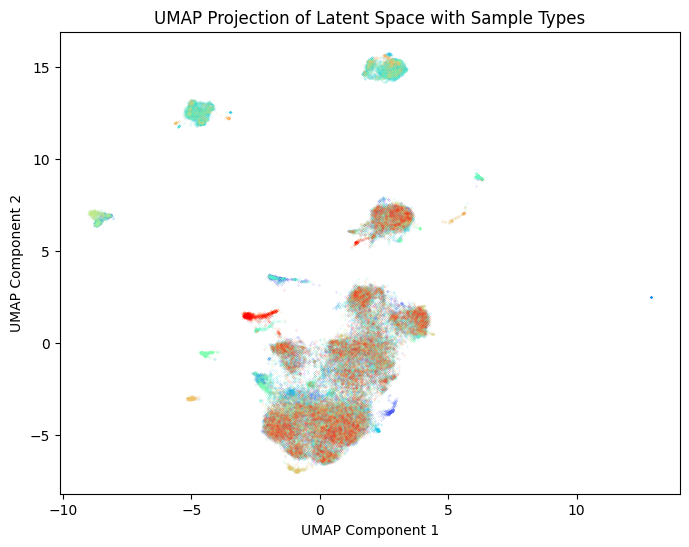

In [ ]:
all_sm = sm_names_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=0.01)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
# plt.legend()
plt.show()



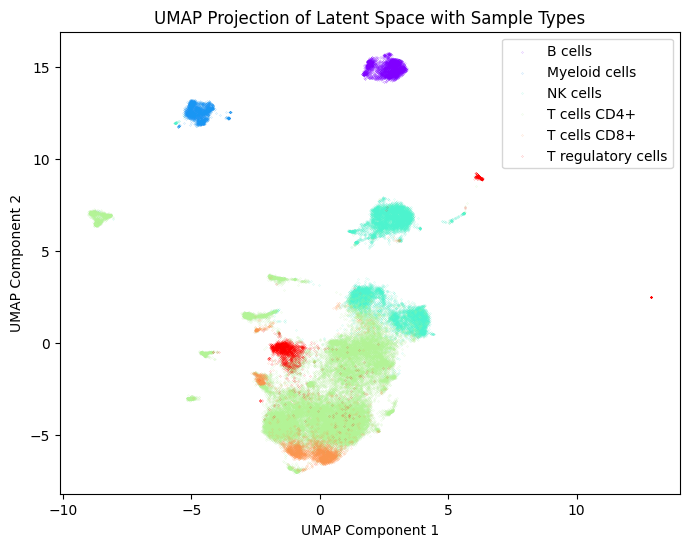

In [ ]:

all_sm = cell_type_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=0.01)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()



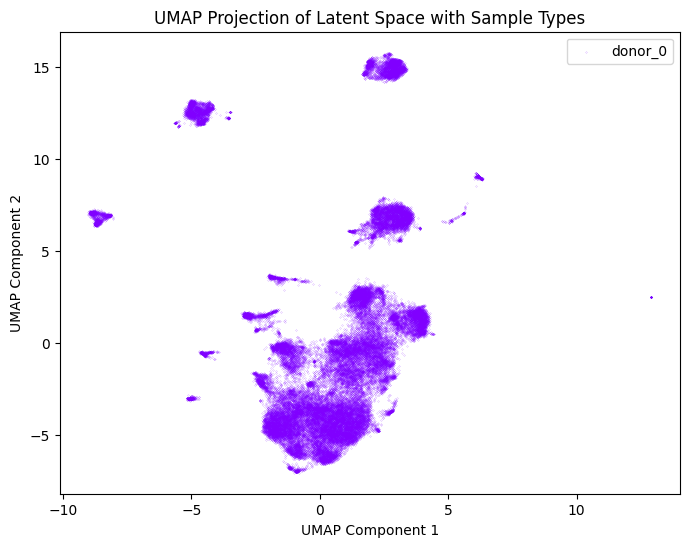

In [ ]:
all_sm = donor_id_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=0.01)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

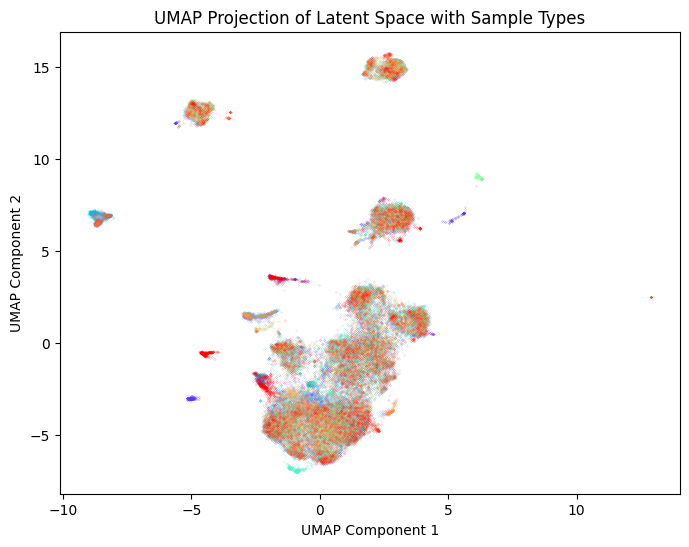

In [ ]:
all_sm = library_id_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=0.01)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
# plt.legend()
plt.show()

In [ ]:
reconstructed_data, mu, logvar, pp = vae_model(batch_data)

In [ ]:
reconstructed_data

tensor([[0.0126, 0.0209, 0.0049,  ..., 0.0866, 0.0803, 0.1010],
        [0.0083, 0.0062, 0.0018,  ..., 0.0486, 0.0440, 0.0801],
        [0.0084, 0.0295, 0.0028,  ..., 0.1242, 0.1247, 0.2150],
        ...,
        [0.0021, 0.0045, 0.0010,  ..., 0.0569, 0.0816, 0.1088],
        [0.0159, 0.0348, 0.0047,  ..., 0.1155, 0.1838, 0.1026],
        [0.0083, 0.0334, 0.0112,  ..., 0.0428, 0.1470, 0.0616]],
       device='cuda:0', grad_fn=<ExpBackward0>)

In [ ]:
batch_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
# batch_data[0,1] = 300

In [ ]:
x = np.concatenate(batch_data.to("cpu").numpy())
y = np.concatenate(reconstructed_data.to("cpu").detach().numpy())

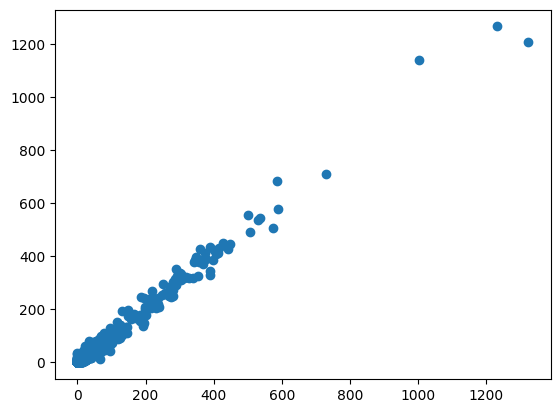

In [ ]:
plt.scatter(x,y)

# Getting hidden vectors

In [ ]:
batch_size = 64
shuffle = True

dataloader = AnnLoader(ad_train, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import numpy as np
batch_size = 64
#data_loader = DataLoader(customdataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store encoded representations and labels
encoded_representations = []

# Run the encoder on the data
sm_names_all = []
cell_type_all = []
with torch.no_grad():  # Disable gradient computation during inference
    for batch_data in dataloader:
        sm_names_all.append(batch_data.obs["sm_name"])
        cell_type_all.append(batch_data.obs["cell_type"])
        batch_data = batch_data.X.to(torch.float32).to(device)  # Assuming you are using GPU, adjust as needed
        mu, _, _ = vae_model.encoder(batch_data)
        encoded_representations.append(mu.cpu().numpy())

sm_names_all = np.concatenate(sm_names_all)
cell_type_all = np.concatenate(cell_type_all)

encoded_representations = np.concatenate(encoded_representations, axis=0)

In [ ]:
len(sm_names_all), len(cell_type_all), encoded_representations.shape

(58240, 58240, (58240, 128))

In [ ]:
enc_cols = ["mu"+str(i) for i in range(encoded_representations.shape[1])]
df_mu_ = pd.DataFrame(encoded_representations, columns=enc_cols)
df_lab_ = pd.DataFrame({"cell_type":cell_type_all, "sm_names":sm_names_all})
df_mu = pd.concat([df_lab_, df_mu_], axis=1)

In [ ]:
# Mean latent vectors for each cell type and perturbation
df_mu_mean = df_mu.groupby(["cell_type", "sm_names"]).median().reset_index()
#df_mu_mean

In [ ]:
# calculate perturbations in latent space
df_deltas = df_mu_mean.copy()
for ct in set(cell_type_all):
  to_subtract = df_deltas.loc[(df_deltas.cell_type==ct)&(df_deltas.sm_names=="Dimethyl Sulfoxide"), enc_cols].values
  df_deltas.loc[df_deltas.cell_type==ct, enc_cols] = df_deltas.loc[df_deltas.cell_type==ct, enc_cols].sub(to_subtract)

In [ ]:
df_deltas

,cell_type,sm_names,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,...,mu118,mu119,mu120,mu121,mu122,mu123,mu124,mu125,mu126,mu127
0,B cells,Alvocidib,-0.046449,-0.017084,0.024217,0.013915,0.016516,0.049161,0.057892,0.042596,...,-0.020296,-2.419062,-1.225894,-0.046401,0.012527,-0.905875,-0.074385,0.044939,0.027422,-0.017378
1,B cells,CHIR-99021,-0.000703,0.002076,0.004082,0.001895,0.004218,0.002065,0.003345,-0.000146,...,-0.000905,-0.337475,-0.455557,-0.002499,-0.004895,-0.228892,0.002664,0.002159,-0.001419,-0.000016
2,B cells,Crizotinib,-0.005353,0.009883,0.000090,0.004328,0.010534,0.006418,-0.000891,0.003516,...,-0.009100,-0.876080,-0.005449,0.001356,0.003357,0.146886,-0.003465,-0.007104,-0.000599,0.001128
3,B cells,Dactolisib,0.000596,0.011499,-0.007605,-0.000275,0.013826,-0.004926,0.000359,-0.000866,...,-0.011973,-0.651180,0.097967,0.005733,0.002631,0.507917,-0.002122,-0.007574,-0.001165,0.005265
4,B cells,Dimethyl Sulfoxide,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,T regulatory cells,Vandetanib,0.003126,-0.001389,0.008611,-0.004613,0.003574,0.000349,0.005208,0.007348,...,-0.006767,-0.447849,-0.155684,0.000848,0.005818,-0.470247,-0.004740,0.004337,0.001637,-0.001451
589,T regulatory cells,Vanoxerine,0.000162,0.001121,0.009882,0.009779,-0.005406,-0.000304,-0.007641,-0.004177,...,0.004729,-0.062234,-0.045784,0.000559,0.009665,-0.353639,0.004614,0.003568,0.007004,0.001751
590,T regulatory cells,Vardenafil,0.004633,-0.001263,0.002142,0.000319,0.006595,0.004885,0.003455,-0.003947,...,0.005921,-0.273738,-0.478177,-0.001250,-0.002221,0.170268,-0.000527,-0.001278,-0.005122,-0.001764
591,T regulatory cells,Vorinostat,0.006447,0.000125,-0.017874,-0.006843,0.003333,-0.001973,0.010256,0.012121,...,-0.001273,-1.356578,-0.100759,-0.010842,-0.005396,0.943408,0.008865,-0.020335,0.017974,0.010917


<Axes: >

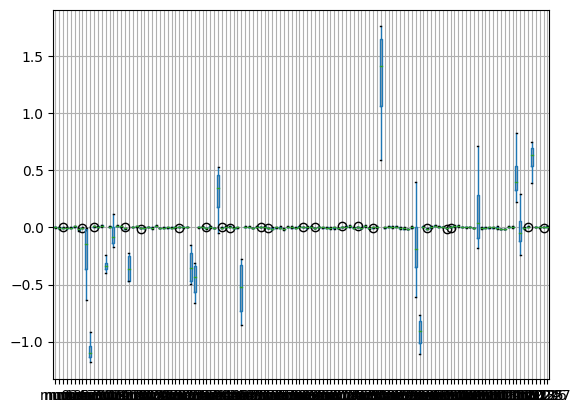

In [ ]:
df_deltas.loc[df_deltas.sm_names=="BMS-265246", enc_cols].boxplot()

In [ ]:
df_deltas.loc[df_deltas.sm_names=="BMS-265246", enc_cols]

,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,mu9,...,mu118,mu119,mu120,mu121,mu122,mu123,mu124,mu125,mu126,mu127
51,-0.004664,0.001456,-0.001721,-0.003243,-0.006309,0.003046,-0.009220,-0.000559,-0.018882,-1.078048,...,0.002933,0.222190,0.290406,-0.013293,0.008397,0.386298,0.002243,0.001353,0.002598,0.008375
195,0.005023,-0.004727,-0.000440,-0.004283,-0.000504,0.007906,-0.017804,-0.002677,-0.267097,-1.117492,...,0.001016,0.436434,-0.078775,-0.001502,0.007443,0.593567,0.002783,0.005096,0.005120,0.005361
336,0.005219,-0.012301,0.006749,-0.008423,0.006159,0.010957,-0.014370,-0.002608,-0.639117,-1.183003,...,-0.000995,0.827837,-0.245246,-0.000596,0.008717,0.680976,0.003504,0.005964,0.003072,0.004433
469,0.001787,0.001526,-0.001036,0.001467,-0.004507,0.009901,-0.030922,-0.006153,-0.005782,-0.918531,...,0.008561,0.357920,-0.027100,-0.006618,0.001832,0.745676,0.003067,-0.003991,-0.003645,0.010981


In [ ]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

In [ ]:
# Cosine similarities between perturbations for different cell types
df_cossim = pd.DataFrame()
for sm in set(sm_names_all):
  cosine_sim_matrix = cosine_similarity(df_deltas.loc[df_deltas.sm_names==sm, enc_cols])
  np.fill_diagonal(cosine_sim_matrix, np.nan)
  df0 = pd.DataFrame({"sm_names":[sm], "cos_sim":[np.nanmean(cosine_sim_matrix)]})
  df_cossim = pd.concat([df_cossim, df0])
  #print(f"{sm}: {np.nanmean(cosine_sim_matrix)}")
df_cossim

,sm_names,cos_sim
0,GO-6976,0.548826
0,Phenylbutazone,0.202424
0,Vardenafil,0.466062
0,CGM-097,0.726430
0,Prednisolone,0.737481
...,...,...
0,Clomipramine,0.242443
0,Dactolisib,0.763312
0,Oprozomib (ONX 0912),0.397281
0,RN-486,0.550477


<Axes: >

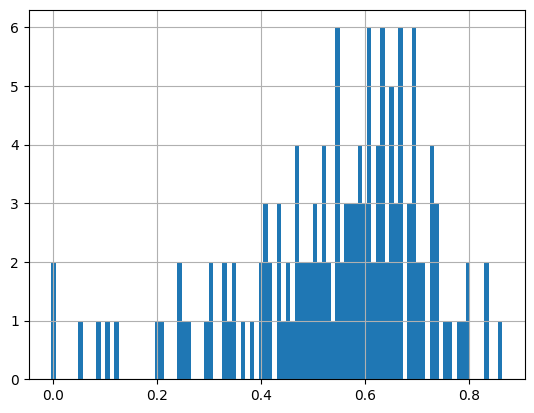

In [ ]:
df_cossim.cos_sim.hist(bins=100)

In [ ]:
df_deltas_mean = df_deltas.drop(columns="cell_type").groupby(["sm_names"]).mean().reset_index()
df_deltas_mean

,sm_names,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,...,mu118,mu119,mu120,mu121,mu122,mu123,mu124,mu125,mu126,mu127
0,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,-0.002549,-0.751948,0.000074,-0.004898,-0.001605,0.001158,-0.002984,-0.090569,0.000915,...,-0.001093,0.001907,0.004264,-0.003302,-0.000901,0.005042,0.002476,0.003024,0.004359,0.286992
1,ABT-199 (GDC-0199),0.003990,-0.241559,-0.001522,0.004663,-0.003973,0.001245,0.000055,-0.047065,-0.001528,...,0.002220,-0.001035,-0.001490,-0.002229,-0.004190,0.001759,-0.000887,0.001454,-0.003243,-0.684272
2,ABT737,0.000896,0.172597,-0.001419,0.002601,-0.002451,0.000548,0.003885,0.139614,-0.000549,...,0.000298,-0.001680,-0.001327,0.000132,0.000128,-0.000064,-0.000727,0.003343,-0.001836,0.012169
3,AMD-070 (hydrochloride),-0.003057,0.090229,0.001596,-0.000653,0.001609,-0.001037,0.001015,-0.239473,-0.000709,...,-0.003593,-0.000819,0.000858,0.000465,-0.000044,-0.002351,-0.001106,0.001760,-0.002195,0.063036
4,AT 7867,-0.004406,-0.022869,-0.000788,0.003622,-0.005543,0.002711,-0.003316,0.304243,0.003286,...,-0.001984,0.000689,0.003721,-0.002328,-0.003178,-0.003992,0.000470,-0.002458,0.000932,-0.071726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Vandetanib,-0.001394,0.312922,0.000764,0.001420,-0.001929,-0.000158,0.000743,0.615126,0.004593,...,0.003507,-0.001040,0.000843,-0.002571,0.002115,-0.003663,0.000380,0.000865,0.000833,-0.055605
141,Vanoxerine,0.003518,0.467067,-0.001359,0.001486,-0.001313,0.002636,-0.003587,0.438495,0.003712,...,0.005538,0.003231,0.001259,-0.006168,-0.000456,-0.001911,-0.002694,-0.001308,0.002020,0.013697
142,Vardenafil,-0.005448,0.071948,0.001310,-0.003014,0.000645,0.000502,0.000173,-0.063343,-0.000794,...,-0.002193,-0.004103,0.003954,0.003107,0.000035,0.000226,0.002818,0.000008,-0.001632,0.252317
143,Vorinostat,-0.022290,0.055890,0.005244,0.002346,-0.003295,0.000792,0.002505,-0.538146,0.009148,...,-0.013224,-0.004623,0.008926,0.001160,-0.008701,-0.008021,0.001039,-0.001603,-0.005592,1.292232
